In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found. Make sure your GPU is properly installed and configured.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully.")

GPU configured successfully.


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate GPU memory growth
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [4]:
import tensorflow as tf

# Check if TensorFlow can access GPU
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))

if num_gpus > 0:
    print("Num GPUs Available: ", num_gpus)
    print("TensorFlow is using GPU.")
else:
    print("No GPU available. TensorFlow is using CPU.")

Num GPUs Available:  1
TensorFlow is using GPU.


In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image,tf.float32)
    return image

In [6]:
path = "/kaggle/input/monumentimagenotaugmented/"
x = load(os.path.join(path, 'train/Train_3221.jpg'))
print(x.shape)

(300, 300, 3)


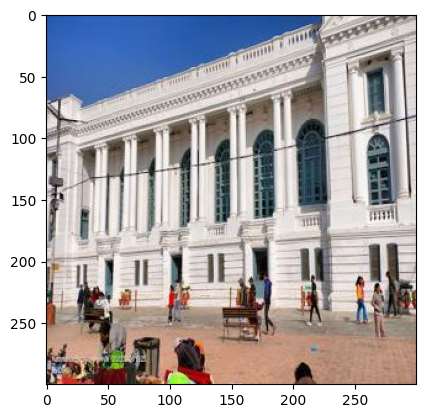

In [7]:
plt.imshow(x/255.0)

In [8]:
def normalize(real_image):
    real_image = (real_image / 255)
    return real_image

In [9]:
def random_crop(real_image):
    cropped_image = tf.image.random_crop(real_image, size = [256, 256, 3])
    return cropped_image

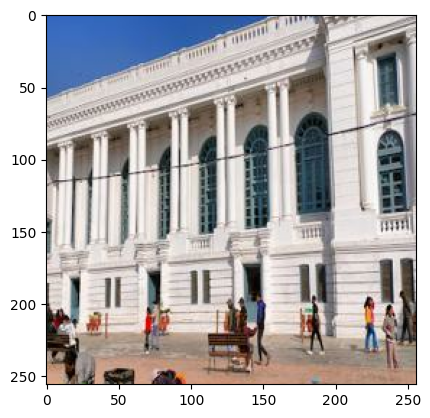

In [10]:
x_aug = random_crop(x)
plt.imshow(x_aug/255.0)

In [11]:
def resize(real_image):
    real_image = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image

In [12]:
def rotate_image(image, angles, interpolation='BILINEAR'):
    """
    Rotate an image tensor by specified angles.

    Args:
    - image: Input image tensor with shape (batch_size, height, width, channels).
    - angles: Tensor of rotation angles in radians for each image in the batch.
    - interpolation: Interpolation method ('BILINEAR' or 'NEAREST').

    Returns:
    - Rotated image tensor.
    """
    batch_size, height, width, channels = tf.unstack(tf.shape(image))

    # Coordinates of the center of the image
    center_x = tf.cast(width, tf.float32) / 2.0
    center_y = tf.cast(height, tf.float32) / 2.0

    # Define transformation matrix
    rotation_matrix = tf.reshape(tf.stack([tf.cos(angles), -tf.sin(angles), center_x * (1 - tf.cos(angles)) + center_y * tf.sin(angles),
                                           tf.sin(angles), tf.cos(angles), -center_x * tf.sin(angles) + center_y * (1 - tf.cos(angles)),
                                           0.0, 0.0, 1.0], axis=1), shape=(-1, 3, 3))

    # Apply rotation to each pixel
    rotated_image = tfa.image.transform(image, rotation_matrix, interpolation)

    return rotated_image


In [13]:
def random_jitter(real_image):
    if tf.random.uniform(()) > 0.5:
        real_image = tf.image.flip_left_right(real_image)
    return real_image

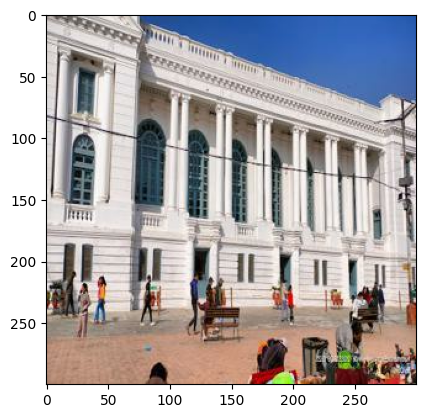

In [14]:
x_jitter = random_jitter(x)
plt.imshow(x_jitter/255.0)

In [15]:
def load_train_images(image_path):
    real_image = load(image_path)
    real_image = tf.image.random_brightness(real_image, 0.2)
    real_image = random_crop(real_image)
    # Define the rotation angle in radians
    rotation_angle = tf.constant(20.0 * (3.141592653589793 / 180.0), dtype=tf.float32)

    # Apply the rotation using tfa.image.rotate
    real_image = tfa.image.rotate(real_image, angles=rotation_angle)

#     # Example usage
#     angles = tf.placeholder(dtype=tf.float32, shape=(None,))
#     # Specify the rotation range in degrees
#     rotation_range = 15  # Adjust this value as needed
#     # Convert the rotation range to radians
#     rotation_range_rad = rotation_range * (np.pi / 180.0)
#     # Generate random rotation angles for each image in the batch
#     random_angles = tf.random.uniform(shape=(tf.shape(image)[0],), minval=-rotation_range_rad, maxval=rotation_range_rad)
#     # Apply custom rotation to the image with bilinear interpolation
#     real_image = rotate_image(real_image, random_angles, interpolation='BILINEAR')
    #     real_image = rotate(real_image)
    real_image = random_jitter(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [16]:
def load_test_image(image_path):
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 8

In [18]:
# create input pipeline
train_dataset = tf.data.Dataset.list_files(path + "train/*.jpg")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [19]:
validation_dataset = tf.data.Dataset.list_files(path + 'val/*.jpg')
validation_dataset = validation_dataset.map(load_test_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [20]:
test_dataset = tf.data.Dataset.list_files(path + 'test/*.jpg')
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [21]:
# downsample block
def downsample(filters, size,dropout=False, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
    if dropout == True :
        result.add(Dropout(0.3))
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)

(1, 150, 150, 3)


In [22]:
# upsample block
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.3))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 300, 300, 3)


In [23]:
def generator(input_shape = (256,256,1), output_channels = 2):
    inputs = Input(shape = input_shape)
    down_stack = [
        downsample(32, 4, batchnorm=False),
        downsample(32, 4),
        downsample(64, 4),
        downsample(64, 4, dropout = True),
        downsample(128, 4, dropout = True),
        downsample(256, 4, dropout = True),
        downsample(512, 4, dropout = True),
        downsample(512, 4, dropout = True)
    ]


    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(256, 4, dropout=True),
        upsample(128, 4, dropout=True),
        upsample(64, 4, dropout=True),
        upsample(64, 4, dropout=True),
        upsample(32, 4),
        upsample(32, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(2, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs = inputs, outputs = x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128, 128, 32)         512       ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 32)           16512     ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 64)           33024     ['sequential_3[0][0]']        
                                                                                              

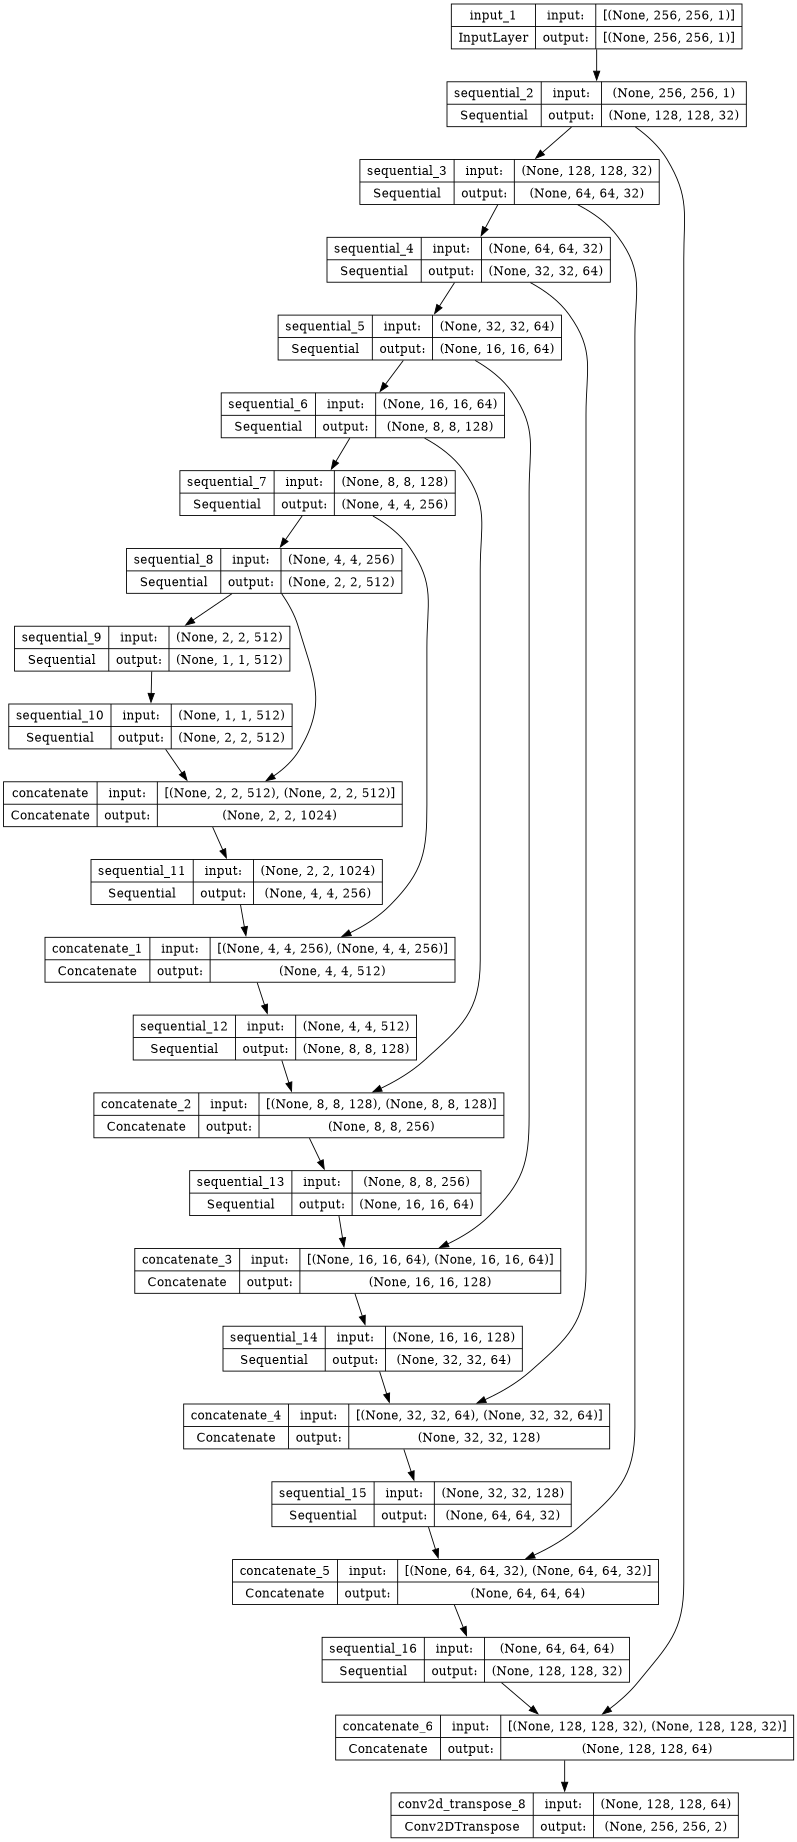

In [24]:
gen = generator()
gen.summary()
plot_model(gen, show_shapes=True, dpi = 64)

In [25]:
gen.load_weights('/kaggle/input/pix2pixmodelweights/gen_weight.keras')

In [26]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 1], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 2], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 2)]        0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 256, 256, 3)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 sequential_17 (Sequential)  (None, 128, 128, 64)         3328      ['concatenate_7[0][0]'] 

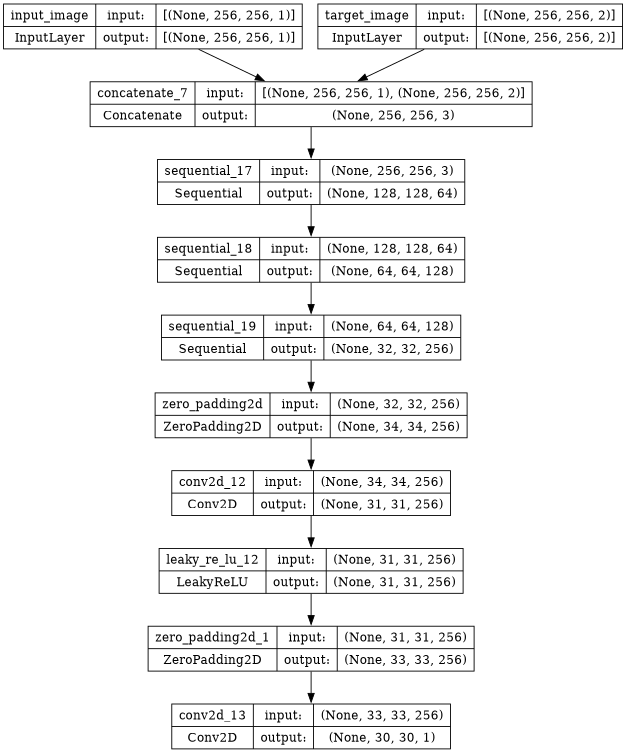

In [27]:
disc = discriminator()
disc.summary()
plot_model(disc, show_shapes=True, dpi = 64)

In [28]:
disc.load_weights('/kaggle/input/pix2pixmodelweights/disc_weight.keras')

In [29]:
# Function to create YUV image from Y, U, and V channels and then convert to rgb
def create_rgb_image(y_channel, uv_channel):
    # Assuming YUV format where Y, U, and V channels are separate
    # y_channel = np.array(y_channel)
    # uv_channel = np.array(uv_channel)
    u_channel, v_channel = tf.split(uv_channel, num_or_size_splits=2, axis=-1)

    # Combine Y, U, and V channels into a YUV image
    rgb_image = tf.image.yuv_to_rgb(tf.concat([y_channel, u_channel, v_channel], axis=-1))
    return rgb_image


In [30]:
LAMBDA = 30

In [31]:
# Define the perceptual loss function
def perceptual_loss(y_true, y_pred):
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
    vgg.trainable = False
    for layer in vgg.layers:
        layer.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    model.trainable = False

    y_true_features = model(y_true)
    y_pred_features = model(y_pred)

    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

In [32]:
def generator_loss(disc_generated_output,input_, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    p_loss = perceptual_loss(create_rgb_image(input_, gen_output), create_rgb_image(input_, target))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + 60*p_loss
    return total_gen_loss, gan_loss, l1_loss, p_loss

In [33]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss, real_loss, generated_loss

In [35]:
generator_optimizer = Adam(lr= 0.0004500000213738531, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

In [36]:
epochs = 250

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load the VGG19 model
vgg = VGG19(weights='imagenet', include_top=False)

# Select the layers you want to use for the LPIPS score
selected_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']

# Create a model that outputs the selected layers
outputs = [vgg.get_layer(name).output for name in selected_layers]
model = Model(inputs=vgg.input, outputs=outputs)

# Make sure the VGG model is not trainable
model.trainable = False

def lpips_score(image1, image2):
    # Get the features for both images
    image1_features = model(image1)
    image2_features = model(image2)

    # Initialize the score
    score = 0

    # For each feature layer...
    for f1, f2 in zip(image1_features, image2_features):
        # ... compute the mean squared error between the features
        mse = tf.reduce_mean((f1 - f2)**2)
        # ... and add it to the score
        score += mse

    return score

80134624/80134624 [==============================] - 1s 0us/step


In [38]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

# Load the pre-trained InceptionV3 model (weights will be downloaded if not present)
pretrained_model = InceptionV3(weights='imagenet', include_top=True, pooling='avg')

# Optionally, you can freeze the layers to prevent training
for layer in pretrained_model.layers:
    layer.trainable = False


# Create a new model to extract features from an intermediate layer
inception_model = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('avg_pool').input)
def calculate_fid_score(images1, images2, inception_model):
    # Ensure the batch dimension is removed for individual image predictions
    images1 = np.squeeze(images1, axis=0)
    images2 = np.squeeze(images2, axis=0)
    
    # Resize images to the required size for the Inception model
    images1 = tf.image.resize(images1, size=(299, 299))
    images2 = tf.image.resize(images2, size=(299, 299))
    
    # Extract features using the Inception model
    features1 = inception_model.predict(np.expand_dims(images1, axis=0))
    features2 = inception_model.predict(np.expand_dims(images2, axis=0))

    # Remove batch dimension from features
    features1 = np.squeeze(features1, axis=0)
    features2 = np.squeeze(features2, axis=0)
    #print(features1.shape)
    # Calculate mean and covariance of feature representations
    mean1 = np.mean(features1, axis=(0, 1, 2))
    mean2 = np.mean(features2, axis=(0, 1, 2))
    #print(features1.shape)
    cov1 = np.cov(features1.transpose(2, 0, 1).reshape(features1.shape[-1], -1), rowvar=False)
    cov2 = np.cov(features2.transpose(2, 0, 1).reshape(features2.shape[-1], -1), rowvar=False)
    #print(cov2.shape)

    # Calculate the squared Euclidean distance between means
    sum_squared_diff = np.sum((mean1 - mean2)**2)

    # Calculate the trace of the product of covariances
    cov_sqrt = sqrtm(np.dot(cov1, cov2))
    trace_cov_product = np.trace(cov1 + cov2 - 2 * cov_sqrt)

    # Calculate FID score
    fid_score = np.real(sum_squared_diff + trace_cov_product)
    
    return fid_score

96112376/96112376 [==============================] - 1s 0us/step


In [39]:
@tf.function
def train_step(input_image, target, epoch, training_discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training=True)
        disc_real_output = disc([input_image, target], training=True)
        disc_generated_output = disc([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
        disc_loss, disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
        rgb_target = create_rgb_image(input_image, target)
        rgb_generated = create_rgb_image(input_image, gen_output)
        ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
        psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
        lpips_values = lpips_score(rgb_target, rgb_generated)

        if epoch > 8:
            if training_discriminator:
                discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
            else:
                generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
                generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        else:
            generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
            generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values

In [40]:
@tf.function
def validation_step(input_image, target):
    # Generate output using the generator
    gen_output = gen(input_image)

    # Calculate losses without updating gradients
    disc_real_output = disc([input_image, target])
    disc_generated_output = disc([input_image, gen_output])

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
    disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
    rgb_target = create_rgb_image(input_image, target)
    rgb_generated = create_rgb_image(input_image, gen_output)
    ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
    psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
    lpips_values = lpips_score(rgb_target, rgb_generated)
    #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values

In [41]:
@tf.function
def test_step(input_image, target):
    # Generate output using the generator
    gen_output = gen(input_image)

    # Calculate losses without updating gradients
    disc_real_output = disc([input_image, target])
    disc_generated_output = disc([input_image, gen_output])

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
    disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
    rgb_target = create_rgb_image(input_image, target)
    rgb_generated = create_rgb_image(input_image, gen_output)
    ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
    psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
    lpips_values = lpips_score(rgb_target, rgb_generated)
    fid_values = calculate_fid_score(rgb_target, rgb_generated, inception_model)
    #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values, fid_values


In [42]:
os.mkdir('/kaggle/working/gen_output/')

In [43]:
def display_one_random_test_image(input_, target, gen_model, epoch):
    print("Displaying one random test image...")
    img_array = np.array(input_)
    generated_output_test = gen_model(input_)
    ssim = tf.image.ssim(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)
    psnr = tf.image.psnr(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)  
    lpips = lpips_score(tf.reshape(create_rgb_image(input_, target), (1,256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1,256,256,3)))
    p_loss = perceptual_loss(create_rgb_image(input_, target), create_rgb_image(input_, generated_output_test))
    fid_score = calculate_fid_score(tf.reshape(create_rgb_image(input_, target), (1,256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1,256,256,3)), inception_model)
    # print(input_.shape)
    input_ = np.squeeze(input_, axis=0)
    # print(type(input_), type(target))
    # print(input_.shape, input_)
    # input_.reshape((256,256))
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 4, 1)
    plt.title('Input Testing Image')
    plt.imshow(input_, cmap='gray', vmax = 1, vmin = 0)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # print(target.shape)
    target = np.squeeze(target, axis=0)
    # # print(target.shape)
    target_img = create_rgb_image(input_, target).numpy()
    # # print(type(target_img))
    # target
    # # print(target_img.shape, target_img)
    plt.subplot(1, 4, 2)
    plt.title('Target Testing Image')
    plt.imshow(target_img)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # Convert PIL Image to NumPy array
    # img_array = np.array(input_)
    # # Add batch dimension
    # # print(img_array.shape)
    # img_array = np.expand_dims(img_array, axis=0)
    # # print(img_array.shape)
    # generated_output_test = gen_model(img_array)
    # # print(generated_output_test.shape)
    # # Squeeze the singleton dimension
    generated_output_test = np.squeeze(generated_output_test, axis=0)
    # # print(generated_output_test.shape)
    generated_img = create_rgb_image(input_, generated_output_test).numpy()
    # # print(generated_img.shape, generated_img)
    plt.subplot(1, 4, 3)
    plt.title(f'Generated Output -- epoch {epoch}')
    plt.imshow(generated_img)  # Assuming images are normalized to [-1, 1]
    plt.axis('off')
    plt.savefig(f'/kaggle/working/gen_output/epoch_{epoch+39}.png')
    plt.show()
    print('SSIM Score: {}'.format(ssim))
    print('PSNR Score: {}'.format(psnr))
    print('LPIPS Score: {}'.format(lpips))
    print('Perceptual Loss: {}'.format(p_loss))
    print('FID Score: {}'.format(fid_score))

In [44]:
def display_random_test_image(gen_model, image_path, epoch):
    
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:] 

    # Display the image
    display_one_random_test_image(tf.reshape(Y_channel, (1,256,256,1)),tf.reshape(UV_channels,(1,256,256,2)), gen_model, epoch)


Displaying one random test image...
1/1 [==============================] - 0s 25ms/step


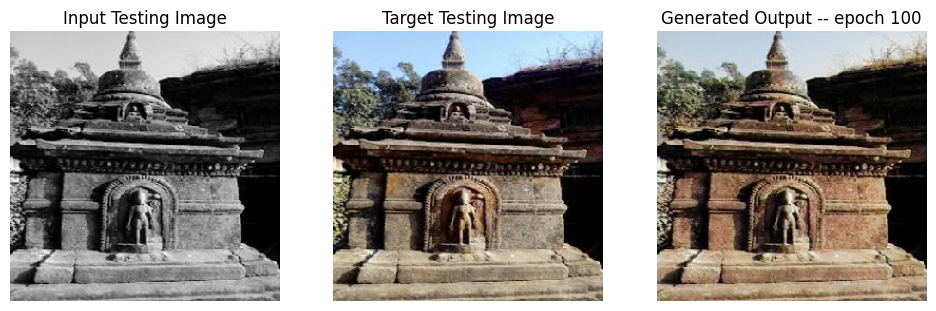

SSIM Score: 0.9724355340003967
PSNR Score: 26.634355545043945
LPIPS Score: 0.5883713960647583
Perceptual Loss: 0.003590967273339629
FID Score: 0.3413983402939525


In [45]:
display_random_test_image(gen, '/kaggle/input/monumentimagenotaugmented/val/Val_1020.jpg',100)

In [46]:
import random

each_epoch_train_generator_losses = []
each_epoch_train_generator_gan_losses = []
each_epoch_train_generator_l1_losses = []
each_epoch_train_generator_l2_losses = []
each_epoch_train_generator_perceptual_losses = []
each_epoch_train_discriminator_losses = []
each_epoch_train_discriminator_real_losses = []
each_epoch_train_discriminator_generated_losses = []
each_epoch_train_ssim = []
each_epoch_train_psnr = []
each_epoch_train_lpips = []
each_epoch_test_lpips = []
each_epoch_test_psnr = []
each_epoch_test_ssim = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_generator_l2_losses = []
each_epoch_test_generator_perceptual_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []
train_generator_losses = []
train_generator_gan_losses = []
train_generator_l1_losses = []
train_generator_l2_losses = []
train_generator_perceptual_losses = []
train_discriminator_losses = []
train_discriminator_real_losses = []
train_discriminator_generated_losses = []
test_generator_losses = []
test_generator_gan_losses = []
test_generator_l1_losses = []
test_generator_l2_losses = []
test_generator_perceptual_losses = []
test_discriminator_losses = []
test_discriminator_real_losses = []
test_discriminator_generated_losses =[]
training_ssim = []
training_psnr = []
training_lpips = []
testing_ssim = []
testing_psnr = []
testing_lpips = []
each_epoch_all_records = []
all_records = []
def fit(train_ds, epochs, test_ds, gen_model):

    # Declare global lists
    global each_epoch_train_generator_losses, each_epoch_train_generator_gan_losses, each_epoch_train_generator_l1_losses, each_epoch_train_generator_l2_losses, each_epoch_train_generator_perceptual_losses, each_epoch_train_discriminator_losses,each_epoch_train_discriminator_real_losses, each_epoch_train_discriminator_generated_losses, each_epoch_train_ssim, each_epoch_train_psnr
    global each_epoch_test_psnr, each_epoch_test_ssim, each_epoch_test_generator_losses, each_epoch_test_generator_gan_losses, each_epoch_test_generator_l1_losses, each_epoch_test_generator_l2_losses, each_epoch_test_generator_perceptual_losses, each_epoch_test_discriminator_losses, each_epoch_test_discriminator_real_losses, each_epoch_test_discriminator_generated_losses
    global train_generator_losses, train_generator_gan_losses, train_generator_l1_losses, train_generator_l2_losses, train_generator_perceptual_losses, train_discriminator_losses, train_discriminator_real_losses, train_discriminator_generated_losses, test_generator_losses, test_generator_l2_losses, test_generator_gan_losses, test_generator_l1_losses, test_generator_perceptual_losses, test_discriminator_losses, test_discriminator_real_losses, test_discriminator_generated_losses
    global training_ssim, training_psnr, testing_ssim, testing_psnr, each_epoch_all_records, all_records, LAMBDA, each_epoch_train_lpips, each_epoch_test_lpips, training_lpips, testing_lpips


    # Initialize counters and flags
    consecutive_epochs_high_loss = 0
    training_discriminator = True
    stop_training = False
    min_learning_rate = 1e-7  # Set your desired minimum learning rate
    time_start = time.time()
    
    for epoch in range(epochs):
        start = time.time()
        train_count = 0
        test_count = 0

        print(f"Epoch {epoch+39}")

        for n, (input_, target) in train_ds.enumerate():
            if epoch > 10:
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss,train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips = train_step(input_, target, epoch, training_discriminator=training_discriminator)

            else:
                # If epoch is less than or equal to 10, train both generator and discriminator
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss, train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips  = train_step(input_, target, epoch, training_discriminator=None)

            each_epoch_train_generator_losses.append(train_gen_loss)
            each_epoch_train_generator_gan_losses.append(train_gen_gan_loss)
            each_epoch_train_generator_l1_losses.append(train_gen_l1_loss)
#             each_epoch_train_generator_l2_losses.append(train_gen_l2_loss)
            each_epoch_train_generator_perceptual_losses.append(train_gen_perceptual_loss)
            each_epoch_train_discriminator_losses.append(train_disc_loss)
            each_epoch_train_discriminator_real_losses.append(train_disc_real_loss)
            each_epoch_train_discriminator_generated_losses.append(train_disc_generated_loss)
            each_epoch_train_ssim.append(tf.reduce_mean(train_ssim.numpy()))
            each_epoch_train_psnr.append(tf.reduce_mean(train_psnr.numpy()))
            each_epoch_train_lpips.append(tf.reduce_mean(train_lpips.numpy()))
#             print(train_count)
            train_count += 1
#             print(n)
        #each_epoch_train_generator_losses = np.array(each_epoch_train_generator_losses)
        #print(each_epoch_train_discriminator_losses.shape())
        #print(each_epoch_train_generator_losses.shape())
        #print(each_epoch_train_ssim())
        print("Training Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f} perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_train_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch + 1+39, time.time() - start))
        print(f"Number of iteration {train_count}")

        train_generator_losses.append(np.mean(each_epoch_train_generator_losses))
        train_generator_gan_losses.append(np.mean(each_epoch_train_generator_gan_losses))
        train_generator_l1_losses.append(np.mean(each_epoch_train_generator_l1_losses))
#         train_generator_l2_losses.append(np.mean(each_epoch_train_generator_l2_losses))
        train_generator_perceptual_losses.append(np.mean(each_epoch_train_generator_perceptual_losses))
        train_discriminator_losses.append(np.mean(each_epoch_train_discriminator_losses))
        train_discriminator_real_losses.append(np.mean(each_epoch_train_discriminator_real_losses))
        train_discriminator_generated_losses.append(np.mean(each_epoch_train_discriminator_generated_losses))
        training_ssim.append(np.mean(each_epoch_train_ssim))
        training_psnr.append(np.mean(each_epoch_train_psnr))
        training_lpips.append(np.mean(each_epoch_train_lpips))

        # Test
        for n, (input_, target) in test_ds.enumerate():
            test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips = validation_step(input_, target)
            test_count += 1

            each_epoch_test_generator_losses.append(test_gen_loss)
            each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
            each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
#             each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
            each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
            each_epoch_test_discriminator_losses.append(test_disc_loss)
            each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
            each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
            each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
            each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
            each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
    
        print("Validation Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch+1+39, time.time() - start))
        print(f"Number of iteration {test_count}")
#         LAMBDA = LAMBDA * 1.006
        test_generator_losses.append(np.mean(each_epoch_test_generator_losses))
        test_generator_gan_losses.append(np.mean(each_epoch_test_generator_gan_losses))
        test_generator_l1_losses.append(np.mean(each_epoch_test_generator_l1_losses))
#         test_generator_l2_losses.append(np.mean(each_epoch_test_generator_l2_losses))
        test_generator_perceptual_losses.append(np.mean(each_epoch_test_generator_perceptual_losses))
        test_discriminator_losses.append(np.mean(each_epoch_test_discriminator_losses))
        test_discriminator_real_losses.append(np.mean(each_epoch_test_discriminator_real_losses))
        test_discriminator_generated_losses.append(np.mean(each_epoch_test_discriminator_generated_losses))
        testing_ssim.append(np.mean(each_epoch_test_ssim))
        testing_psnr.append(np.mean(each_epoch_test_psnr))
        testing_lpips.append(np.mean(each_epoch_test_lpips))

        each_epoch_all_records.append([np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses),np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr)])
        all_records.append(each_epoch_all_records)
        # emptying for next epoch
        each_epoch_test_ssim = []
        each_epoch_test_generator_losses = []
        each_epoch_test_generator_gan_losses = []
        each_epoch_test_generator_l1_losses = []
#         each_epoch_test_generator_l2_losses = []
        each_epoch_test_generator_perceptual_losses = []
        each_epoch_test_discriminator_losses = []
        each_epoch_test_discriminator_real_losses = []
        each_epoch_test_discriminator_generated_losses = []
        each_epoch_test_psnr = []
        each_epoch_test_lpips = []
        each_epoch_all_records = []
        #emptyling list for next iteration
        each_epoch_train_generator_losses = []
        each_epoch_train_generator_gan_losses = []
        each_epoch_train_generator_l1_losses = []
#         each_epoch_train_generator_l2_losses = []
        each_epoch_train_generator_perceptual_losses = []
        each_epoch_train_discriminator_losses = []
        each_epoch_train_discriminator_real_losses = []
        each_epoch_train_discriminator_generated_losses = []
        each_epoch_train_ssim = []
        each_epoch_train_psnr = []
        each_epoch_train_lpips = []
        if time.time() - time_start > 39000:
            stop_training = True
        if epoch == 0 or epoch % 3 == 0:
            # Function to display one random test image
            # def display_random_test_image(images, labels, gen_model):
            #     # Randomly select an index
            #     random_test_image_idx = random.randint(0, len(images) - 1)

            #     # Extract input and target from the selected index
            #     random_test_input = images[random_test_image_idx]
            #     random_test_target = labels[random_test_image_idx]

            #     # Display the image
            #     display_one_random_test_image(random_test_input, random_test_target, gen_model)

            # Example usage
            display_random_test_image(gen, '/kaggle/input/monumentimagenotaugmented/val/Val_1000.jpg', epoch+1)
        # Check if the difference between two consecutive epochs for the last 5 epochs is less than 1
        if epoch > 10:
            # Check 1f the difference between two consecutive epochs for the last S epochs is less than 1 or 0.3
            last_epochs_losses = train_discriminator_losses[-5:] if training_discriminator else train_generator_losses[-5:]
            if all(((last_epochs_losses[i] - last_epochs_losses[i - 1])) < 0.01 if training_discriminator else ((last_epochs_losses[1] - last_epochs_losses[i - 1])) < 0.05 for i in range(1, 5)):
                consecutive_epochs_high_loss += 1
            else:
                consecutive_epochs_high_loss = 0
        
        
#         LAMBDA = LAMBDA*1.003
            # If the condition is met for 4 consecutive epochs, reduce the learning rate
        if consecutive_epochs_high_loss == 4:
            if training_discriminator:
                current_lr = generator_optimizer. learning_rate.numpy()
                new_lr = max (current_lr * 0.45, min_learning_rate)
                if new_lr > min_learning_rate:
                    generator_optimizer.learning_rate.assign(new_lr)
                    print (f"Reduced generator learning rate to {new_lr} at epoch {epoch + 1}")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Generator learning rate already at the minimum. Stopping training.")
                    stop_training = True
            else:
                current_lr = discriminator_optimizer.learning_rate.numpy()
                new_lr = max (current_lr * 0.3, min_learning_rate)
                if new_lr > min_learning_rate:
                    discriminator_optimizer.learning_rate.assign(new_lr)
                    print(f"Reduced discriminator learning rate to {new_lr} at epoch {epoch + 1}.")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Discriminator learning rate already at the minimum. Stopping training.")
                    stop_training = True

                consecutive_epochs_high_loss = 0
        # Check the flag variable
        if stop_training:
            break

In [47]:
tf.config.run_functions_eagerly(True)

Epoch 39
Training Details
Generator-- total_loss:2.25327 gan_loss:0.81950 l1_loss:0.03511 perceptual_loss:0.00634 Discriminator-- total_loss:1.61585 real_loss:0.81982 generated_loss:0.79603 --- SSIM 0.93852 PSNR 24.59878 LPIPS 1.04173
Time taken for epoch 40 is 1032.2567565441132 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.53467 gan_loss:0.52833 l1_loss:0.04856  perceptual_loss:0.00916 Discriminator-- total_loss:1.47418 real_loss:0.91232 generated_loss:0.56187 --- SSIM 0.93391 PSNR 22.62530 LPIPS 1.29198
Time taken for epoch 40 is 1204.4793536663055 sec
Number of iteration 280
Displaying one random test image...


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 181ms/step


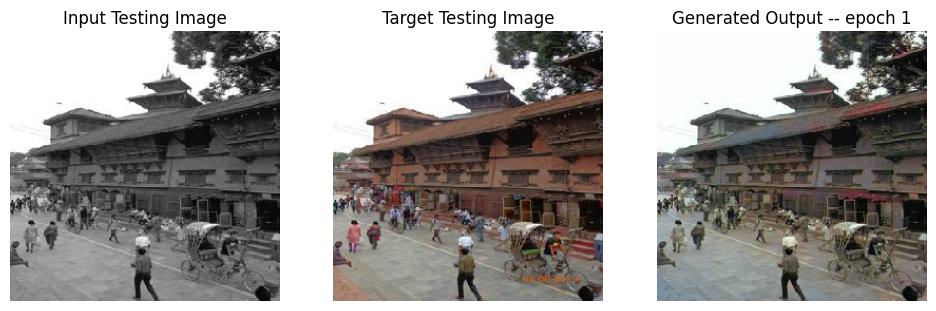

SSIM Score: 0.9661970734596252
PSNR Score: 28.203258514404297
LPIPS Score: 0.755155086517334
Perceptual Loss: 0.00723438523709774
FID Score: 2.7274437929273763
Epoch 40
Training Details
Generator-- total_loss:2.24979 gan_loss:0.76675 l1_loss:0.03649 perceptual_loss:0.00647 Discriminator-- total_loss:1.38153 real_loss:0.68901 generated_loss:0.69251 --- SSIM 0.93810 PSNR 24.24291 LPIPS 1.07849
Time taken for epoch 41 is 1036.391470193863 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.41239 gan_loss:0.49279 l1_loss:0.04633  perceptual_loss:0.00883 Discriminator-- total_loss:1.47452 real_loss:0.96713 generated_loss:0.50739 --- SSIM 0.93362 PSNR 22.92296 LPIPS 1.18906
Time taken for epoch 41 is 1208.9819281101227 sec
Number of iteration 280
Epoch 41
Training Details
Generator-- total_loss:2.28215 gan_loss:0.77204 l1_loss:0.03714 perceptual_loss:0.00660 Discriminator-- total_loss:1.36916 real_loss:0.68280 generated_loss:0.68637 --- SSIM 0.93614 PSNR 24.12426 LPIPS 1.

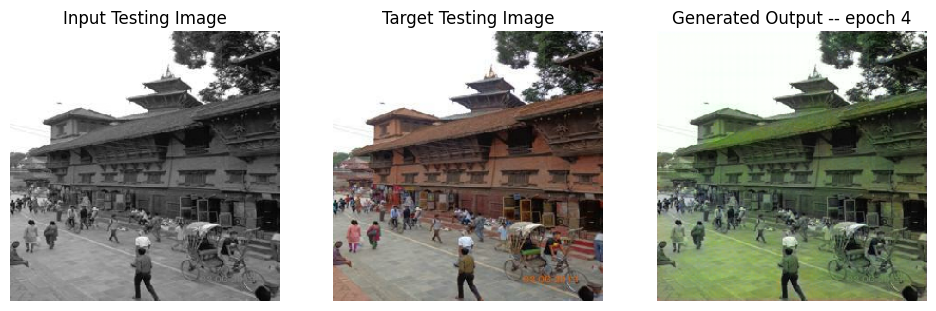

SSIM Score: 0.9474740028381348
PSNR Score: 24.075483322143555
LPIPS Score: 0.9691992998123169
Perceptual Loss: 0.006810389459133148
FID Score: 1.5837732040024632
Epoch 43
Training Details
Generator-- total_loss:2.30555 gan_loss:0.77514 l1_loss:0.03741 perceptual_loss:0.00680 Discriminator-- total_loss:1.36221 real_loss:0.67725 generated_loss:0.68496 --- SSIM 0.93243 PSNR 24.00218 LPIPS 1.17784
Time taken for epoch 44 is 1039.4994668960571 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.35354 gan_loss:0.64696 l1_loss:0.04066  perceptual_loss:0.00811 Discriminator-- total_loss:1.38990 real_loss:0.77787 generated_loss:0.61203 --- SSIM 0.93534 PSNR 23.79357 LPIPS 1.18211
Time taken for epoch 44 is 1214.8375329971313 sec
Number of iteration 280
Epoch 44
Training Details
Generator-- total_loss:2.30883 gan_loss:0.77593 l1_loss:0.03737 perceptual_loss:0.00687 Discriminator-- total_loss:1.35935 real_loss:0.67694 generated_loss:0.68241 --- SSIM 0.93182 PSNR 23.99829 LPIPS

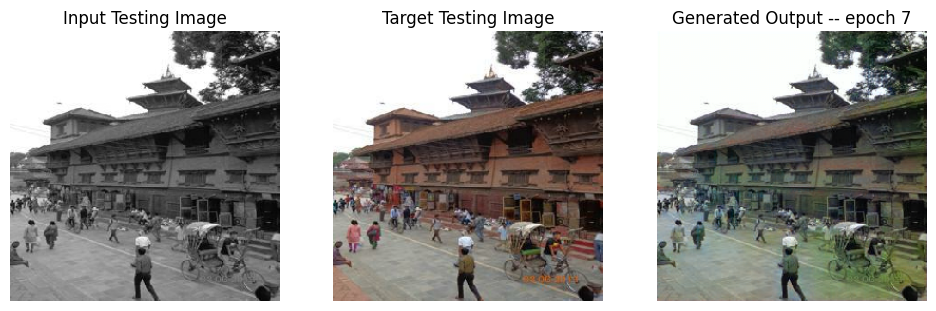

SSIM Score: 0.9620741009712219
PSNR Score: 26.734468460083008
LPIPS Score: 0.7369071841239929
Perceptual Loss: 0.0062048062682151794
FID Score: 1.7683429554095809
Epoch 46
Training Details
Generator-- total_loss:2.33357 gan_loss:0.78674 l1_loss:0.03767 perceptual_loss:0.00695 Discriminator-- total_loss:1.34967 real_loss:0.67073 generated_loss:0.67895 --- SSIM 0.93095 PSNR 23.95868 LPIPS 1.21936
Time taken for epoch 47 is 1025.3127541542053 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.29104 gan_loss:0.47906 l1_loss:0.04322  perceptual_loss:0.00859 Discriminator-- total_loss:1.49507 real_loss:1.09193 generated_loss:0.40314 --- SSIM 0.92742 PSNR 23.04871 LPIPS 1.28580
Time taken for epoch 47 is 1200.208550453186 sec
Number of iteration 280
Epoch 47
Training Details
Generator-- total_loss:2.34154 gan_loss:0.79352 l1_loss:0.03762 perceptual_loss:0.00699 Discriminator-- total_loss:1.34661 real_loss:0.66995 generated_loss:0.67666 --- SSIM 0.93075 PSNR 23.97521 LPIPS

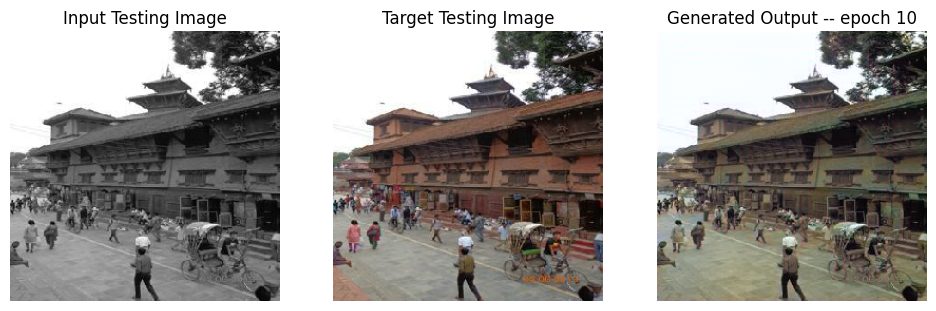

SSIM Score: 0.9581753611564636
PSNR Score: 27.73335838317871
LPIPS Score: 0.7011750936508179
Perceptual Loss: 0.0049672843888401985
FID Score: 1.4254557109876855
Epoch 49
Training Details
Generator-- total_loss:1.74643 gan_loss:0.33179 l1_loss:0.03467 perceptual_loss:0.00624 Discriminator-- total_loss:2.06420 real_loss:1.43419 generated_loss:0.63001 --- SSIM 0.93398 PSNR 24.75573 LPIPS 1.04075
Time taken for epoch 50 is 882.3580346107483 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.16667 gan_loss:0.55167 l1_loss:0.03906  perceptual_loss:0.00739 Discriminator-- total_loss:1.51817 real_loss:0.90828 generated_loss:0.60990 --- SSIM 0.93577 PSNR 24.23619 LPIPS 1.05278
Time taken for epoch 50 is 1061.661744594574 sec
Number of iteration 280
Epoch 50
Training Details
Generator-- total_loss:13.52074 gan_loss:12.13392 l1_loss:0.03394 perceptual_loss:0.00614 Discriminator-- total_loss:0.02803 real_loss:0.01295 generated_loss:0.01508 --- SSIM 0.93345 PSNR 24.99451 LPIPS

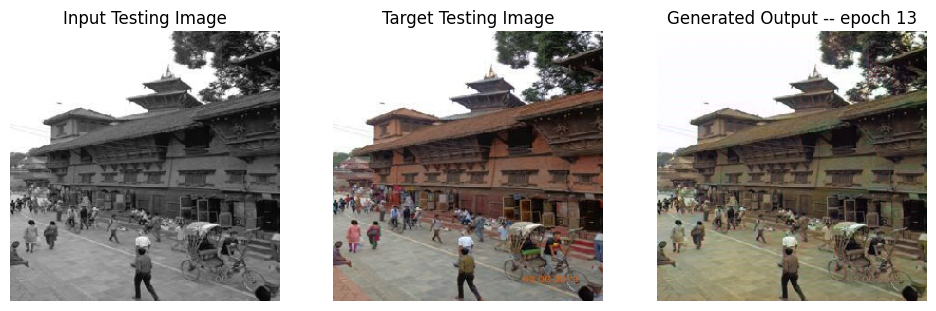

SSIM Score: 0.9588637351989746
PSNR Score: 28.21086311340332
LPIPS Score: 0.7000998258590698
Perceptual Loss: 0.0052129002287983894
FID Score: 1.7544338134665094
Epoch 52
Training Details
Generator-- total_loss:19.40955 gan_loss:18.02312 l1_loss:0.03392 perceptual_loss:0.00615 Discriminator-- total_loss:0.04091 real_loss:0.02113 generated_loss:0.01978 --- SSIM 0.93348 PSNR 24.99283 LPIPS 0.99600
Time taken for epoch 53 is 739.6564347743988 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.59623 gan_loss:0.00322 l1_loss:0.03857  perceptual_loss:0.00727 Discriminator-- total_loss:7.50331 real_loss:7.49269 generated_loss:0.01061 --- SSIM 0.93558 PSNR 24.37019 LPIPS 1.04639
Time taken for epoch 53 is 913.8595514297485 sec
Number of iteration 280
Epoch 53
Training Details
Generator-- total_loss:21.23346 gan_loss:19.84811 l1_loss:0.03390 perceptual_loss:0.00614 Discriminator-- total_loss:0.00016 real_loss:0.00008 generated_loss:0.00008 --- SSIM 0.93347 PSNR 25.00166 LPI

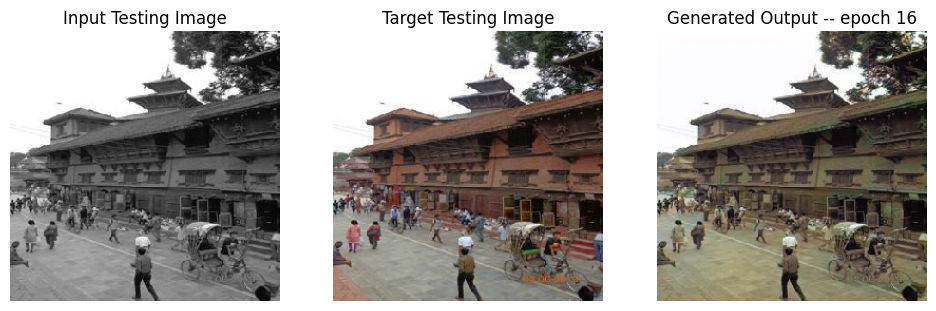

SSIM Score: 0.958805501461029
PSNR Score: 28.254735946655273
LPIPS Score: 0.6999423503875732
Perceptual Loss: 0.005198059603571892
FID Score: 1.7566463277815374
Epoch 55
Training Details
Generator-- total_loss:26.15413 gan_loss:24.76790 l1_loss:0.03392 perceptual_loss:0.00614 Discriminator-- total_loss:0.09825 real_loss:0.05385 generated_loss:0.04440 --- SSIM 0.93343 PSNR 24.99350 LPIPS 0.99673
Time taken for epoch 56 is 737.9898600578308 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.59948 gan_loss:0.00566 l1_loss:0.03859  perceptual_loss:0.00727 Discriminator-- total_loss:11.03195 real_loss:11.02071 generated_loss:0.01125 --- SSIM 0.93567 PSNR 24.36709 LPIPS 1.04617
Time taken for epoch 56 is 916.175746679306 sec
Number of iteration 280
Epoch 56
Training Details
Generator-- total_loss:27.90761 gan_loss:26.52085 l1_loss:0.03394 perceptual_loss:0.00614 Discriminator-- total_loss:0.00013 real_loss:0.00007 generated_loss:0.00006 --- SSIM 0.93343 PSNR 24.99626 LPI

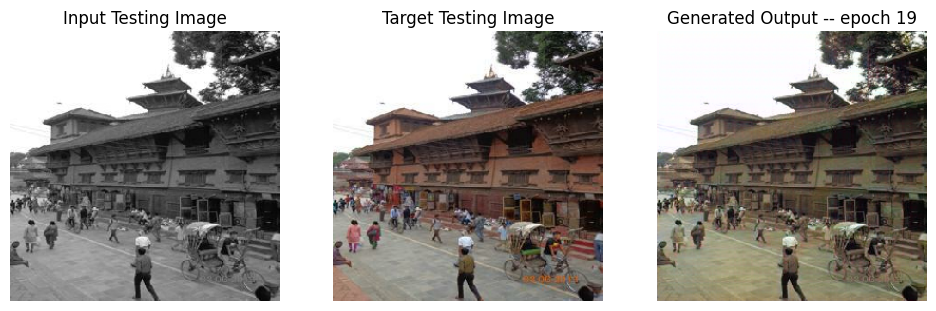

SSIM Score: 0.9587365984916687
PSNR Score: 28.27018928527832
LPIPS Score: 0.7000371217727661
Perceptual Loss: 0.0052185580134391785
FID Score: 1.7627072270000448
Epoch 58
Training Details
Generator-- total_loss:31.67394 gan_loss:30.28832 l1_loss:0.03394 perceptual_loss:0.00612 Discriminator-- total_loss:0.03401 real_loss:0.01564 generated_loss:0.01837 --- SSIM 0.93334 PSNR 24.99205 LPIPS 0.99704
Time taken for epoch 59 is 737.6240730285645 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.59384 gan_loss:0.00062 l1_loss:0.03857  perceptual_loss:0.00727 Discriminator-- total_loss:12.63659 real_loss:12.63491 generated_loss:0.00168 --- SSIM 0.93571 PSNR 24.36339 LPIPS 1.04648
Time taken for epoch 59 is 914.3675332069397 sec
Number of iteration 280
Epoch 59
Training Details
Generator-- total_loss:32.84388 gan_loss:31.45902 l1_loss:0.03389 perceptual_loss:0.00614 Discriminator-- total_loss:0.00008 real_loss:0.00004 generated_loss:0.00004 --- SSIM 0.93347 PSNR 25.00261 L

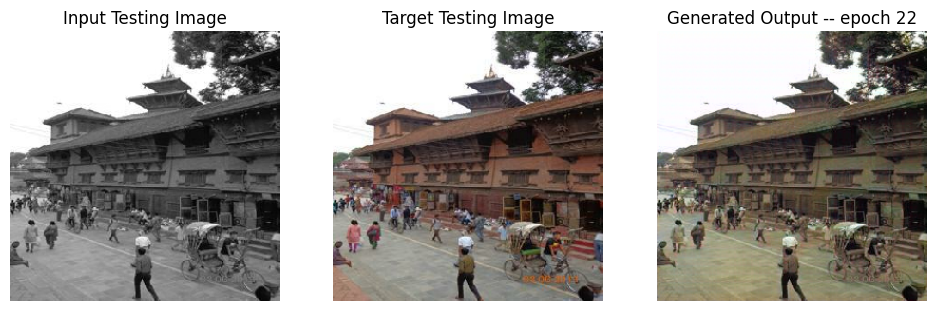

SSIM Score: 0.9588265419006348
PSNR Score: 28.286542892456055
LPIPS Score: 0.6987155079841614
Perceptual Loss: 0.005225833971053362
FID Score: 1.7521517899398282
Epoch 61
Training Details
Generator-- total_loss:34.14954 gan_loss:32.76348 l1_loss:0.03392 perceptual_loss:0.00614 Discriminator-- total_loss:0.02398 real_loss:0.00963 generated_loss:0.01435 --- SSIM 0.93338 PSNR 25.00057 LPIPS 0.99727
Time taken for epoch 62 is 726.0245938301086 sec
Number of iteration 980
Validation Details
Generator-- total_loss:37.25950 gan_loss:35.66492 l1_loss:0.03859  perceptual_loss:0.00728 Discriminator-- total_loss:31.98774 real_loss:3.91173 generated_loss:28.07601 --- SSIM 0.93600 PSNR 24.35658 LPIPS 1.04496
Time taken for epoch 62 is 897.2302105426788 sec
Number of iteration 280
Epoch 62
Training Details
Generator-- total_loss:52.48183 gan_loss:51.09578 l1_loss:0.03392 perceptual_loss:0.00614 Discriminator-- total_loss:0.00138 real_loss:0.00049 generated_loss:0.00089 --- SSIM 0.93344 PSNR 25.00008

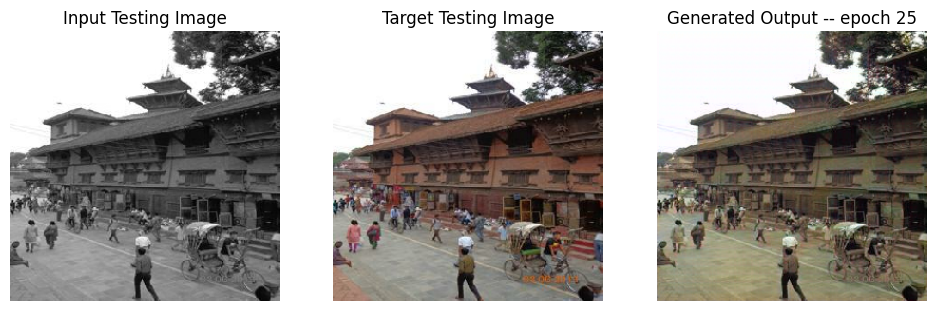

SSIM Score: 0.9586693644523621
PSNR Score: 28.18765640258789
LPIPS Score: 0.7026232481002808
Perceptual Loss: 0.005256349220871925
FID Score: 1.7527351520588412
Epoch 64
Training Details
Generator-- total_loss:74.18539 gan_loss:72.79923 l1_loss:0.03391 perceptual_loss:0.00615 Discriminator-- total_loss:0.02620 real_loss:0.01229 generated_loss:0.01391 --- SSIM 0.93350 PSNR 24.99917 LPIPS 0.99794
Time taken for epoch 65 is 737.4584069252014 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.59392 gan_loss:0.00000 l1_loss:0.03859  perceptual_loss:0.00727 Discriminator-- total_loss:26.28751 real_loss:26.27385 generated_loss:0.01366 --- SSIM 0.93564 PSNR 24.36746 LPIPS 1.04625
Time taken for epoch 65 is 909.3666250705719 sec
Number of iteration 280
Epoch 65
Training Details
Generator-- total_loss:69.64745 gan_loss:68.26217 l1_loss:0.03388 perceptual_loss:0.00615 Discriminator-- total_loss:0.00004 real_loss:0.00003 generated_loss:0.00001 --- SSIM 0.93342 PSNR 25.00389 LP

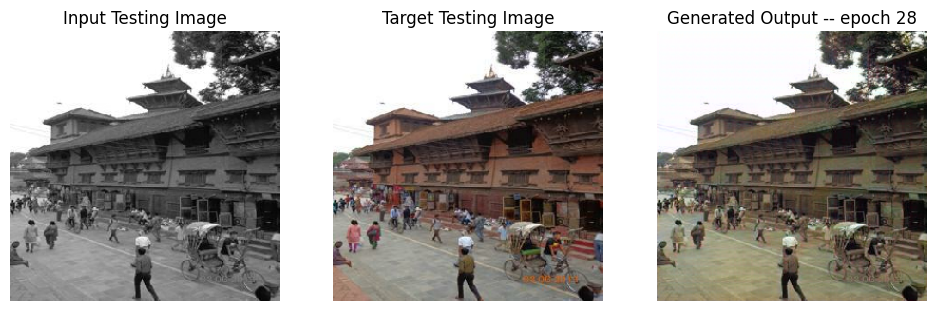

SSIM Score: 0.9585817456245422
PSNR Score: 28.224132537841797
LPIPS Score: 0.7011657953262329
Perceptual Loss: 0.0052300551906228065
FID Score: 1.7715077042608507
Epoch 67
Training Details
Generator-- total_loss:72.05373 gan_loss:70.66361 l1_loss:0.03399 perceptual_loss:0.00617 Discriminator-- total_loss:0.00000 real_loss:0.00000 generated_loss:0.00000 --- SSIM 0.93344 PSNR 24.97999 LPIPS 0.99751
Time taken for epoch 68 is 744.9623456001282 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.59320 gan_loss:0.00000 l1_loss:0.03857  perceptual_loss:0.00727 Discriminator-- total_loss:23.75402 real_loss:23.74646 generated_loss:0.00757 --- SSIM 0.93566 PSNR 24.36843 LPIPS 1.04656
Time taken for epoch 68 is 918.2676811218262 sec
Number of iteration 280
Epoch 68
Training Details
Generator-- total_loss:71.96898 gan_loss:70.58559 l1_loss:0.03385 perceptual_loss:0.00613 Discriminator-- total_loss:0.00000 real_loss:0.00000 generated_loss:0.00000 --- SSIM 0.93360 PSNR 25.01639 

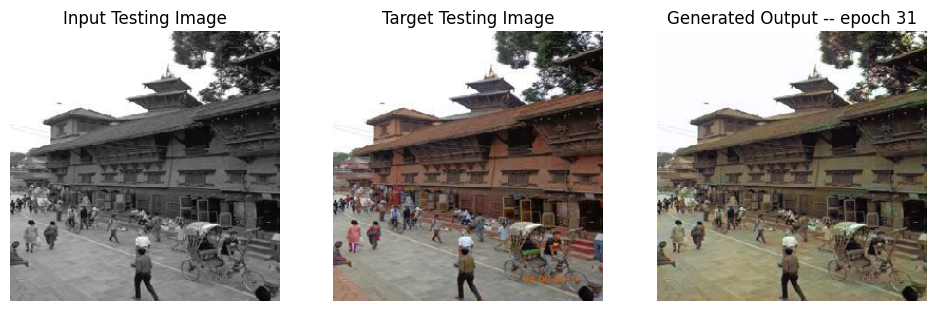

SSIM Score: 0.9585992693901062
PSNR Score: 28.23505973815918
LPIPS Score: 0.7001783847808838
Perceptual Loss: 0.005248839035630226
FID Score: 1.7598539289953758
Epoch 70
Training Details
Generator-- total_loss:71.74483 gan_loss:70.36137 l1_loss:0.03387 perceptual_loss:0.00612 Discriminator-- total_loss:0.08051 real_loss:0.03342 generated_loss:0.04709 --- SSIM 0.93349 PSNR 25.00411 LPIPS 0.99517
Time taken for epoch 71 is 733.9434726238251 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.59289 gan_loss:0.00000 l1_loss:0.03856  perceptual_loss:0.00727 Discriminator-- total_loss:28.88840 real_loss:28.88357 generated_loss:0.00482 --- SSIM 0.93558 PSNR 24.36446 LPIPS 1.04765
Time taken for epoch 71 is 906.206024646759 sec
Number of iteration 280
Epoch 71
Training Details
Generator-- total_loss:73.33678 gan_loss:71.95137 l1_loss:0.03390 perceptual_loss:0.00614 Discriminator-- total_loss:0.00012 real_loss:0.00009 generated_loss:0.00003 --- SSIM 0.93358 PSNR 24.99818 LPI

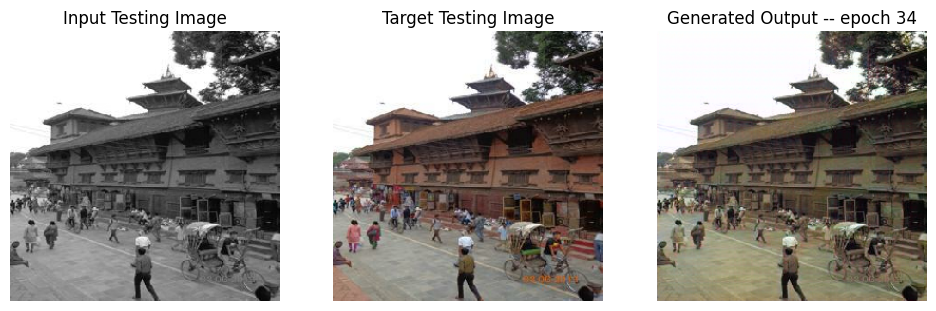

SSIM Score: 0.9584231972694397
PSNR Score: 28.212614059448242
LPIPS Score: 0.7017996311187744
Perceptual Loss: 0.005214083008468151
FID Score: 1.7600405823645078
Epoch 73
Training Details
Generator-- total_loss:73.64801 gan_loss:72.26156 l1_loss:0.03390 perceptual_loss:0.00616 Discriminator-- total_loss:0.00004 real_loss:0.00001 generated_loss:0.00003 --- SSIM 0.93346 PSNR 24.99967 LPIPS 0.99701
Time taken for epoch 74 is 746.88978099823 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.59441 gan_loss:0.00002 l1_loss:0.03859  perceptual_loss:0.00728 Discriminator-- total_loss:22.14956 real_loss:22.14380 generated_loss:0.00577 --- SSIM 0.93575 PSNR 24.35509 LPIPS 1.04654
Time taken for epoch 74 is 919.7369463443756 sec
Number of iteration 280
Epoch 74
Training Details
Generator-- total_loss:72.61136 gan_loss:71.22491 l1_loss:0.03392 perceptual_loss:0.00615 Discriminator-- total_loss:0.00001 real_loss:0.00001 generated_loss:0.00001 --- SSIM 0.93346 PSNR 24.99621 LPI

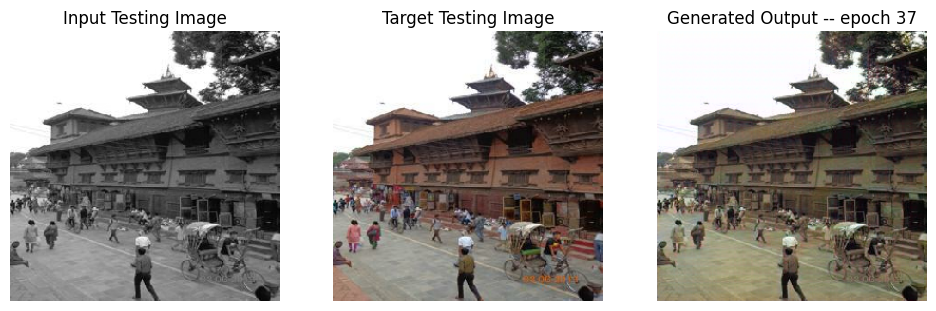

SSIM Score: 0.9584041237831116
PSNR Score: 28.175609588623047
LPIPS Score: 0.7026247382164001
Perceptual Loss: 0.0052411179058253765
FID Score: 1.7635463777942177
Epoch 76
Training Details
Generator-- total_loss:95.17504 gan_loss:93.78938 l1_loss:0.03390 perceptual_loss:0.00614 Discriminator-- total_loss:0.02637 real_loss:0.01070 generated_loss:0.01567 --- SSIM 0.93345 PSNR 25.00152 LPIPS 0.99571
Time taken for epoch 77 is 750.6193768978119 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.73524 gan_loss:0.14125 l1_loss:0.03859  perceptual_loss:0.00727 Discriminator-- total_loss:29.37073 real_loss:29.35770 generated_loss:0.01303 --- SSIM 0.93588 PSNR 24.37229 LPIPS 1.04531
Time taken for epoch 77 is 923.0909280776978 sec
Number of iteration 280
Epoch 77
Training Details
Generator-- total_loss:89.31605 gan_loss:87.92873 l1_loss:0.03394 perceptual_loss:0.00615 Discriminator-- total_loss:0.00012 real_loss:0.00003 generated_loss:0.00008 --- SSIM 0.93354 PSNR 24.99313 

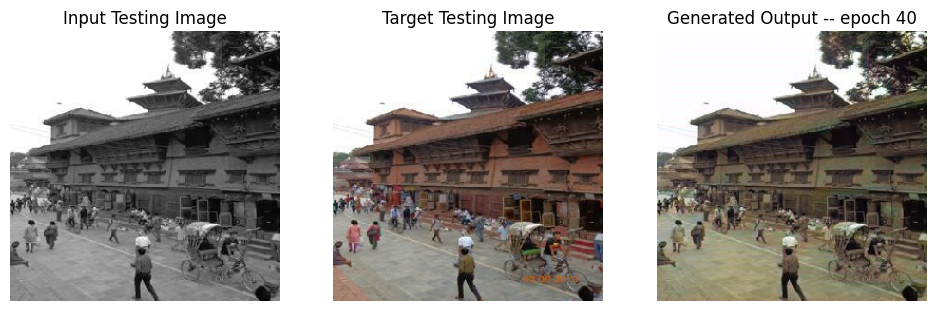

SSIM Score: 0.9585843682289124
PSNR Score: 28.220874786376953
LPIPS Score: 0.7012113928794861
Perceptual Loss: 0.005236482713371515
FID Score: 1.7545771938030366


In [48]:
fit(train_dataset, epochs, validation_dataset, gen)

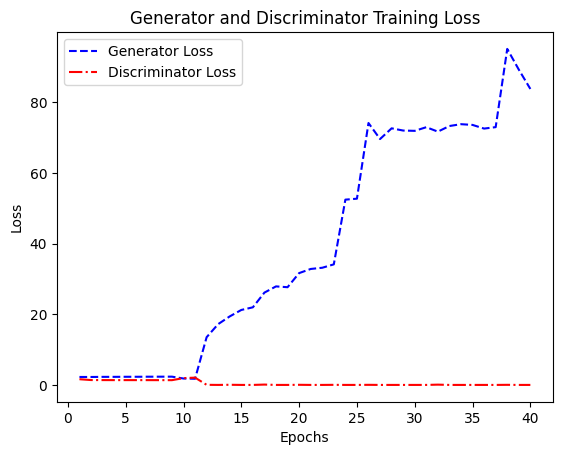

In [49]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, train_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/train_loss_plot_1.png')
plt.show()

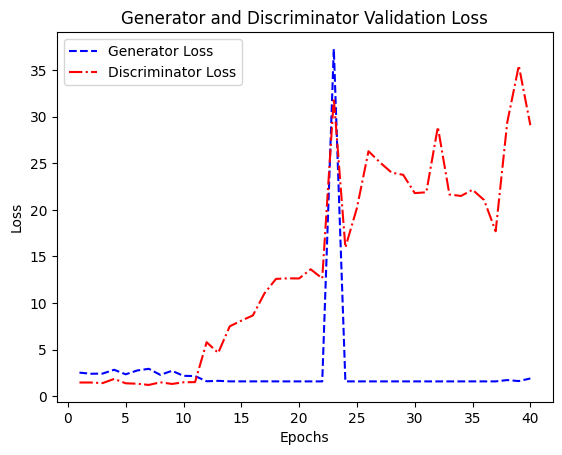

In [50]:
epochs = range(1, len(test_generator_losses) + 1)

plt.plot(epochs, test_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/test_loss_plot_1.png')
plt.show()

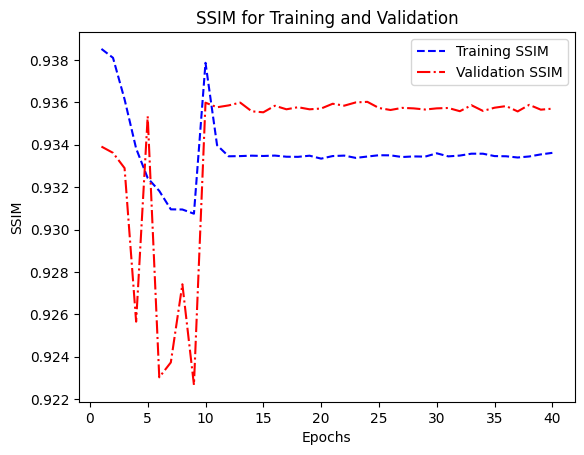

In [51]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_ssim, '--b', label='Training SSIM')
plt.plot(epochs, testing_ssim, '-.r', label='Validation SSIM')
plt.title('SSIM for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.savefig('/kaggle/working/SSIM_plot_1.png')
plt.show()

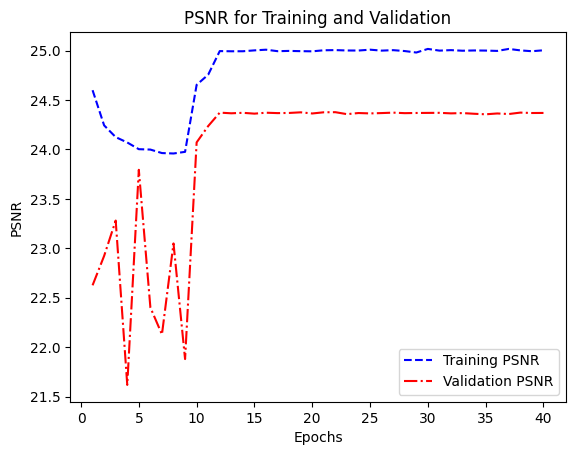

In [52]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_psnr, '--b', label='Training PSNR')
plt.plot(epochs, testing_psnr, '-.r', label='Validation PSNR')
plt.title('PSNR for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.savefig('/kaggle/working/PSNR_plot_1.png')
plt.show()

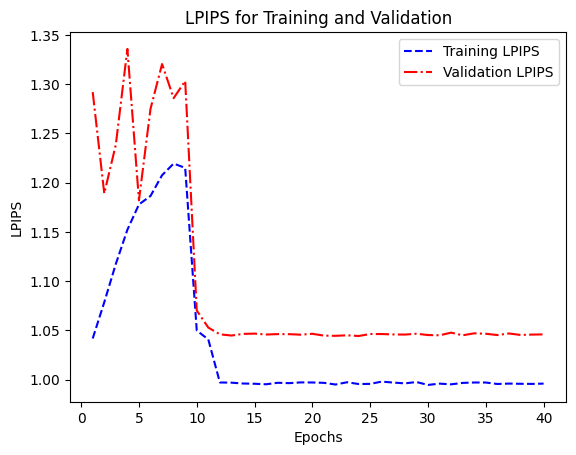

In [53]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_lpips, '--b', label='Training LPIPS')
plt.plot(epochs, testing_lpips, '-.r', label='Validation LPIPS')
plt.title('LPIPS for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('LPIPS')
plt.legend()
plt.savefig('/kaggle/working/LPIPS_plot_1.png')
plt.show()

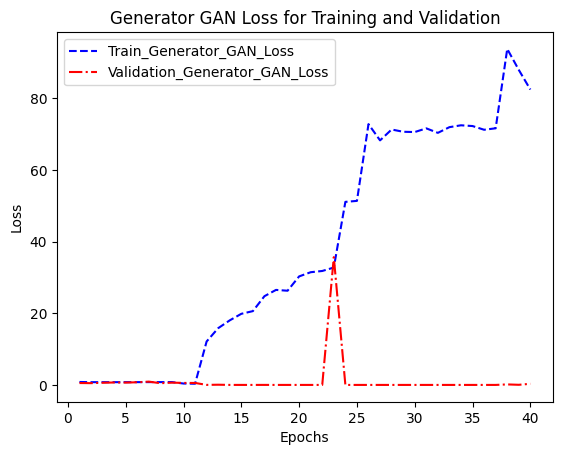

In [54]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_gan_losses, '--b', label='Train_Generator_GAN_Loss')
plt.plot(epochs, test_generator_gan_losses, '-.r', label='Validation_Generator_GAN_Loss')
plt.title('Generator GAN Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_GAN_plot_1.png')
plt.show()

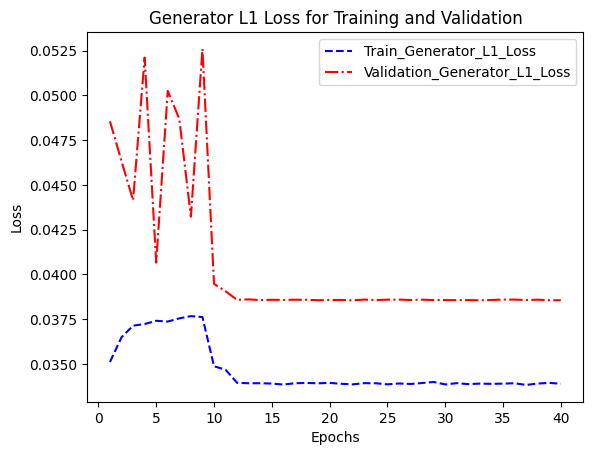

In [55]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_l1_losses, '--b', label='Train_Generator_L1_Loss')
plt.plot(epochs, test_generator_l1_losses, '-.r', label='Validation_Generator_L1_Loss')
plt.title('Generator L1 Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_L1_plot_1.png')
plt.show()

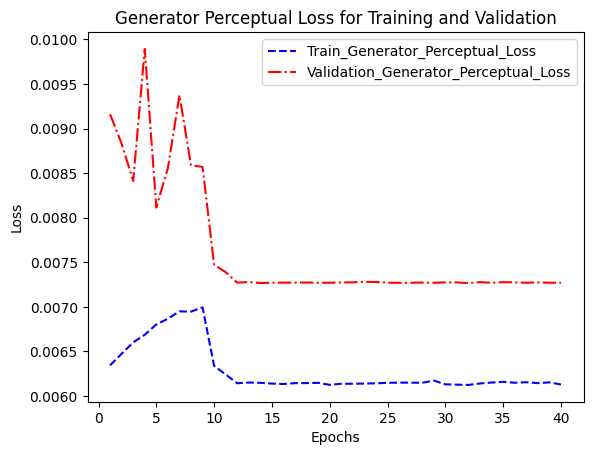

In [56]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_perceptual_losses, '--b', label='Train_Generator_Perceptual_Loss')
plt.plot(epochs, test_generator_perceptual_losses, '-.r', label='Validation_Generator_Perceptual_Loss')
plt.title('Generator Perceptual Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_Perceptual_plot_1.png')
plt.show()

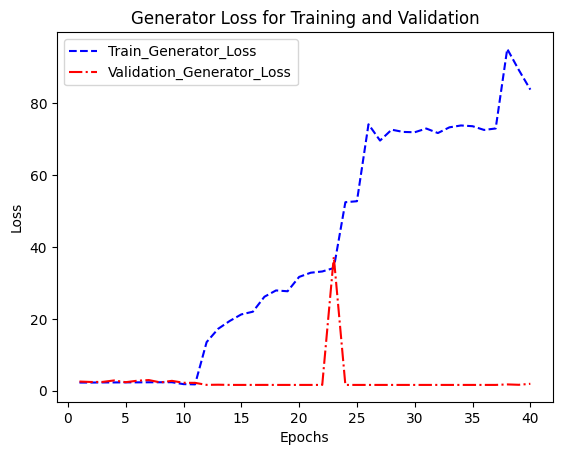

In [57]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Train_Generator_Loss')
plt.plot(epochs, test_generator_losses, '-.r', label='Validation_Generator_Loss')
plt.title('Generator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_plot_1.png')
plt.show()

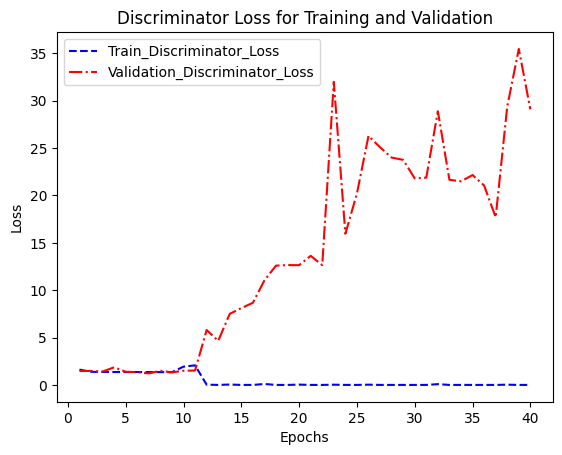

In [58]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_losses, '--b', label='Train_Discriminator_Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Validation_Discriminator_Loss')
plt.title('Discriminator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_plot_1.png')
plt.show()

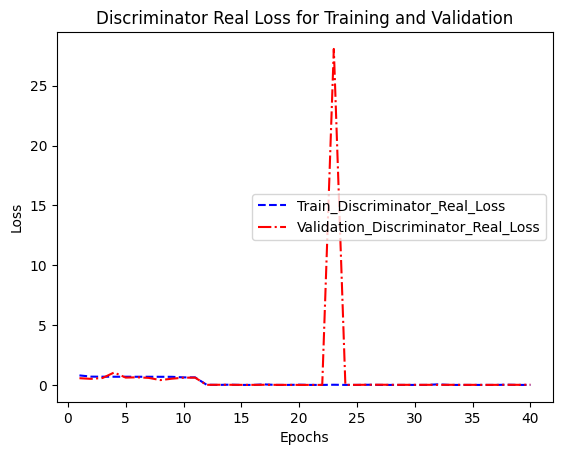

In [59]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_real_losses, '--b', label='Train_Discriminator_Real_Loss')
plt.plot(epochs, test_discriminator_real_losses, '-.r', label='Validation_Discriminator_Real_Loss')
plt.title('Discriminator Real Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Real_plot_1.png')
plt.show()

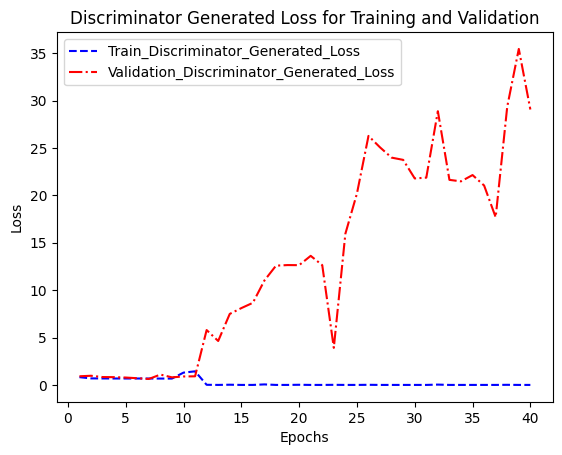

In [60]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_generated_losses, '--b', label='Train_Discriminator_Generated_Loss')
plt.plot(epochs, test_discriminator_generated_losses, '-.r', label='Validation_Discriminator_Generated_Loss')
plt.title('Discriminator Generated Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Generated_plot_1.png')
plt.show()

In [61]:
import csv
with open('/kaggle/working/dataJan20.csv','w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(all_records)

In [62]:
# Evaluation on testing data


each_epoch_test_lpips = []
each_epoch_test_psnr = []
each_epoch_test_ssim = []
each_epoch_test_fid = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_generator_l2_losses = []
each_epoch_test_generator_perceptual_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []

for n, (input_, target) in test_dataset.enumerate():
    test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips, test_fid = test_step(input_, target)

    each_epoch_test_generator_losses.append(test_gen_loss)
    each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
    each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
#             each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
    each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
    each_epoch_test_discriminator_losses.append(test_disc_loss)
    each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
    each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
    each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
    each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
    each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
    each_epoch_test_fid.append(test_fid)
    print(test_fid)

print("Testing Details")
print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  perceptual_loss:{:.5f} \nDiscriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- \nSSIM {:.5f} \nPSNR {:.5f} \nLPIPS {:.5f} \nFID Score: {:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips), np.mean(each_epoch_test_fid)))

1/1 [==============================] - 0s 186ms/step
1.848893031399037
1/1 [==============================] - 0s 182ms/step
2.060767786518642
1/1 [==============================] - 0s 188ms/step
1.0390461036561383
1/1 [==============================] - 0s 183ms/step
1.1355672470570741
1/1 [==============================] - 0s 182ms/step
0.9138266371611155
1/1 [==============================] - 0s 188ms/step
1.8753733079222683
1/1 [==============================] - 0s 174ms/step
0.779314656593181
1/1 [==============================] - 0s 179ms/step
0.6581775054166505
1/1 [==============================] - 0s 175ms/step
6.167456560521184
1/1 [==============================] - 0s 184ms/step
1.3846523054570417
1/1 [==============================] - 0s 181ms/step
0.5439134565644219
1/1 [==============================] - 0s 177ms/step
0.9156208457909606
1/1 [==============================] - 0s 182ms/step
2.569698994549568
1/1 [==============================] - 0s 177ms/step
2.03494081742336

In [63]:
os.mkdir('/kaggle/working/modelsFeb7')

In [64]:
gen.save('/kaggle/working/modelsFeb7/gen.h5')
gen.save_weights('/kaggle/working/modelsFeb7/gen_weight.keras')
disc.save('/kaggle/working/modelsFeb7/disc.h5')
disc.save_weights('/kaggle/working/modelsFeb7/disc_wweight.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode !=0:
        print("Unable to run zip command")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [66]:
import subprocess
from IPython.display import FileLink, display

In [67]:
download_file('/kaggle/working', 'outputFeb10')

/kaggle/working/outputFeb10.zip